In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.optimized_search import OptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import pickle

Using TensorFlow backend.


In [30]:
def get_data(base_path):
    
    with open(base_path + 'acc_drop_w.p', 'rb') as f:
        acc_drop_w = pickle.load(f)
    with open(base_path + 'acc_drop_a.p', 'rb') as f:
        acc_drop_a = pickle.load(f)

    with open(base_path + 'opt_params_w.p', 'rb') as f:
        opt_params_w = pickle.load(f)
    with open(base_path + 'opt_params_a.p', 'rb') as f:
        opt_params_a = pickle.load(f)

    return acc_drop_w, acc_drop_a, opt_params_w, opt_params_a

In [3]:
def get_weights_memory_per_alloc_type(opt_params_w, num_params, direction):
    
    total_memory = {}

    for k in opt_params_w:
        bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
        if direction == 'reverse':
            bw.reverse()
        total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(num_params))])

    memory_consumption = [total_memory[k] for k in total_memory]
    memory_consumption_MB = [i/(8*1024**2) for i in memory_consumption]
    
    return memory_consumption_MB

In [29]:
def get_num_params_per_layer(model):

    num_params = []
    for layer in model_obj.model.layers:
        if layer.weights and layer.name.startswith('conv2d') or layer.name.startswith('dense'):
            w = layer.get_weights()[0]
            num_weights = len(w.flatten())
            print(layer.name, num_weights)
            num_params.append(num_weights)

    return num_params

conv2d_1 288
conv2d_2 9216
conv2d_3 9216
conv2d_4 9216
conv2d_5 9216
conv2d_6 9216
conv2d_7 18432
conv2d_8 36864
conv2d_9 36864
conv2d_10 36864
conv2d_11 36864
conv2d_12 36864
conv2d_13 36864
conv2d_14 36864
dense_1 640


# MNIST

In [41]:
model_path = 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_seq_large.h5'
K.clear_session()
model = keras.models.load_model(model_path)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [14]:
f_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L MNIST/'
f_acc_drop_w, f_acc_drop_a, f_opt_params_w, f_opt_params_a = get_data(f_path)

r_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/R Sequential L MNIST/'
r_acc_drop_w, r_acc_drop_a, r_opt_params_w, f_opt_params_a = get_data(r_path)

In [16]:
layer_names = f_acc_drop_w['constant'].keys()

#### Weights

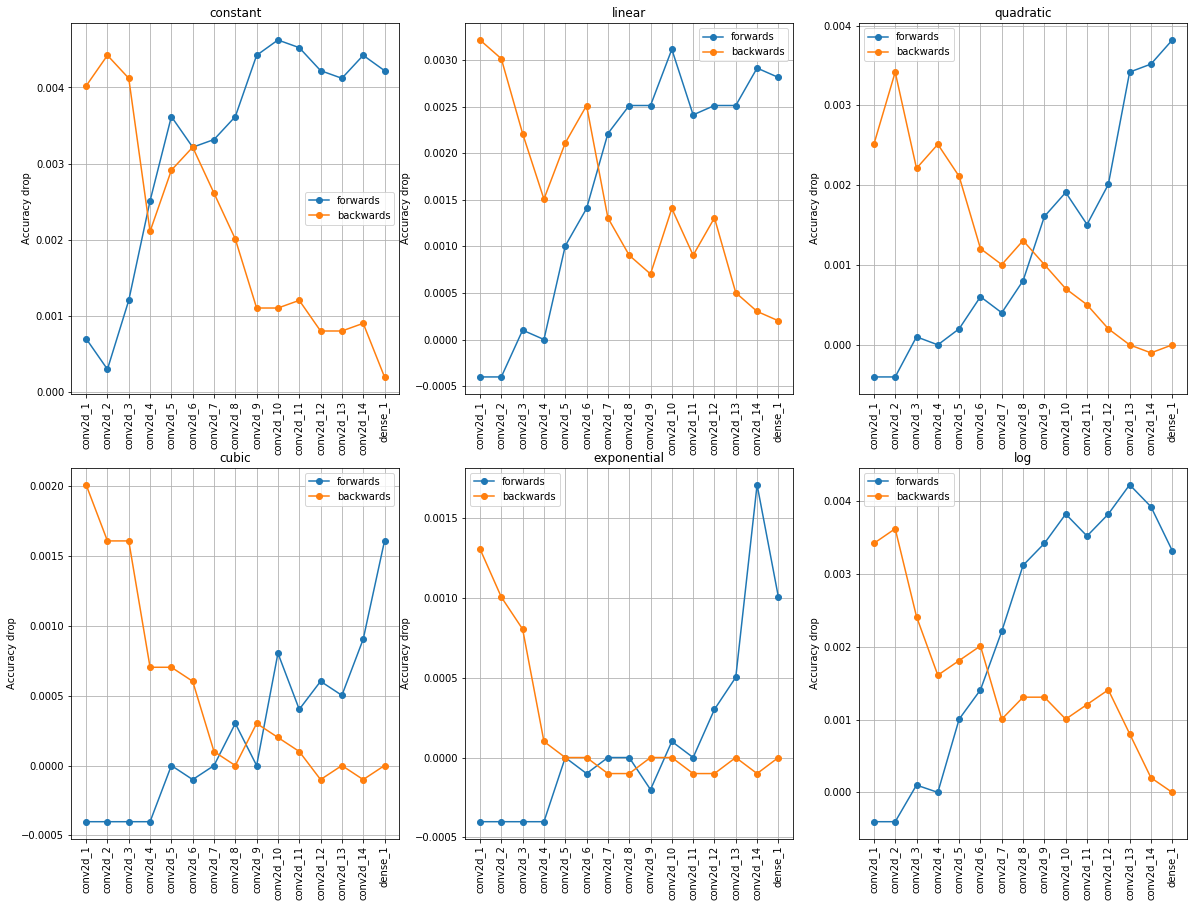

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
ax = axes.flat
x = np.arange(1, len(layer_names) + 1, 1)

for i, k in enumerate(f_acc_drop_w.keys()):
    forwards = [f_acc_drop_w[k][i] for i in f_acc_drop_w[k]]
    backwards = [r_acc_drop_w[k][i] for i in r_acc_drop_w[k]]
    # values are stored in reverse in the dictionary, 
    #hence need to be aligned with the forwards case
    backwards.reverse()
    
    ax[i].plot(x, forwards, 'o-', label='forwards')
    ax[i].plot(x, backwards, 'o-', label='backwards')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    ax[i].set_title(k)
    ax[i].set_ylabel('Accuracy drop')
    ax[i].grid()
    ax[i].legend()

#### Activations

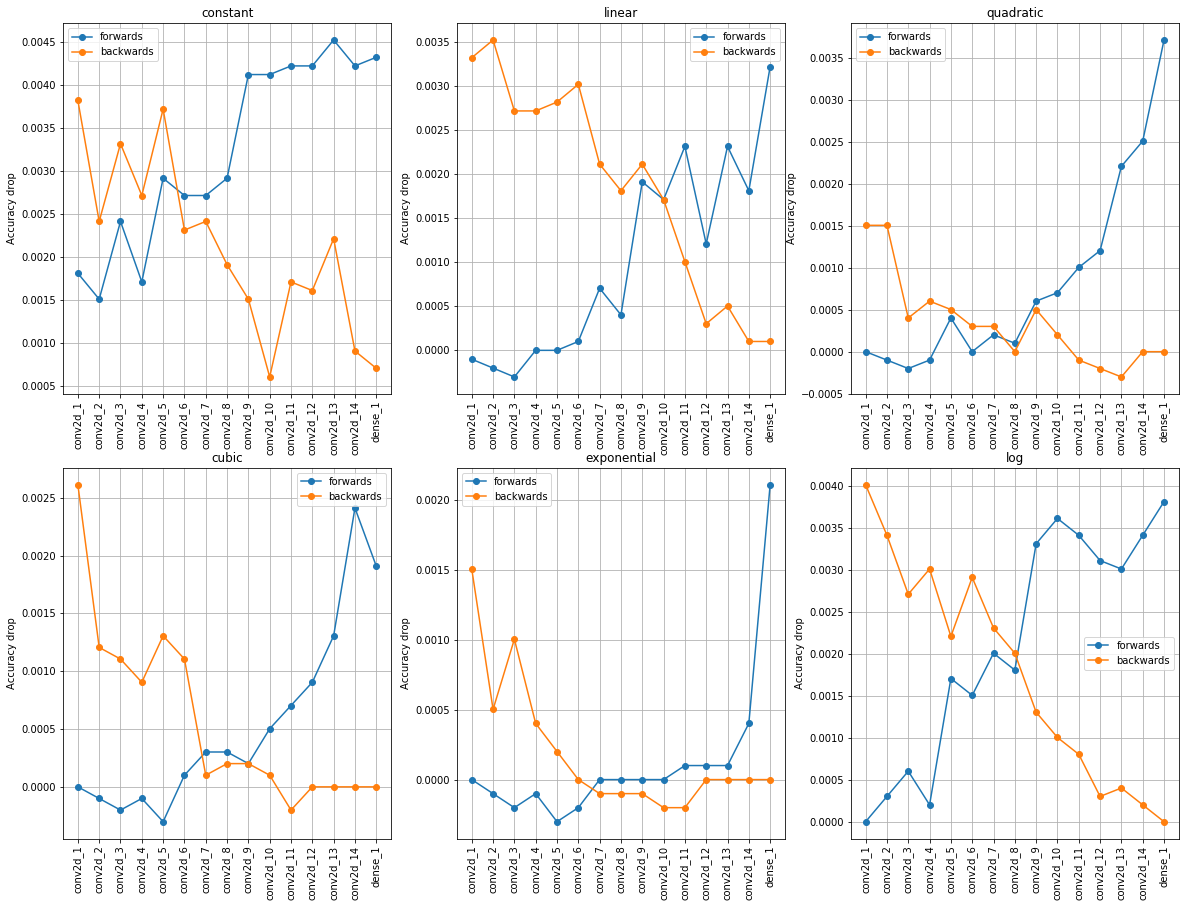

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
ax = axes.flat
x = np.arange(1, len(layer_names) + 1, 1)

for i, k in enumerate(f_acc_drop_a.keys()):
    forwards = [f_acc_drop_a[k][i] for i in f_acc_drop_a[k]]
    backwards = [r_acc_drop_a[k][i] for i in r_acc_drop_a[k]]
    backwards.reverse()
    ax[i].plot(x, forwards, 'o-', label='forwards')
    ax[i].plot(x, backwards, 'o-', label='backwards')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    ax[i].set_title(k)
    ax[i].set_ylabel('Accuracy drop')
    ax[i].grid()
    ax[i].legend()

#### Memory consumption

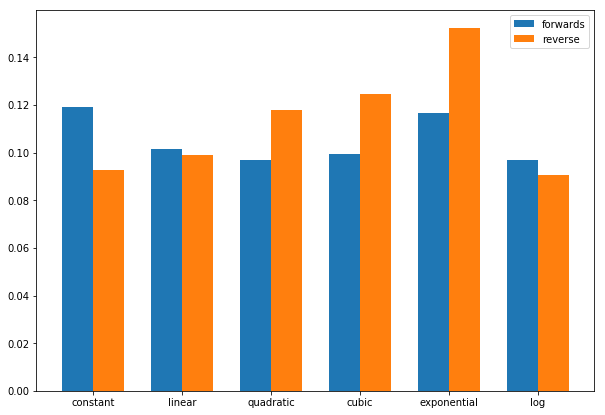

In [38]:
f_memory_MB = get_weights_memory_per_alloc_type(f_opt_params_w, num_params, 'forwards')
r_memory_MB = get_weights_memory_per_alloc_type(r_opt_params_w, num_params, 'reverse')

alloc_types = ['constant', 'linear', 'quadratic', 'cubic', 'exponential', 'log']
plt.figure(figsize=(10, 7))
width = 0.35
x = np.arange(len(f_memory_MB))
plt.bar(x, f_memory_MB, width, label='forwards');
plt.bar(x + width, r_memory_MB, width, label='reverse');
plt.xticks(x + width/2, alloc_types, rotation='horizontal');
plt.legend();

# CIFAR10

In [5]:
f_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L CIFAR10/'
f_acc_drop_w, f_acc_drop_a, f_opt_params_w, f_opt_params_a = get_data(f_path)

r_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/R Sequential L CIFAR10/'
r_acc_drop_w, r_acc_drop_a, r_opt_params_w, f_opt_params_a = get_data(r_path)

In [6]:
layer_names = f_acc_drop_w['constant'].keys()

In [ ]:
num_params = [864, 9216, 9216, 9216, 9216, 9216, 18432, 36864, 36864, 36864, 36864, 36864, 36864, 36864, 640]

#### Weights

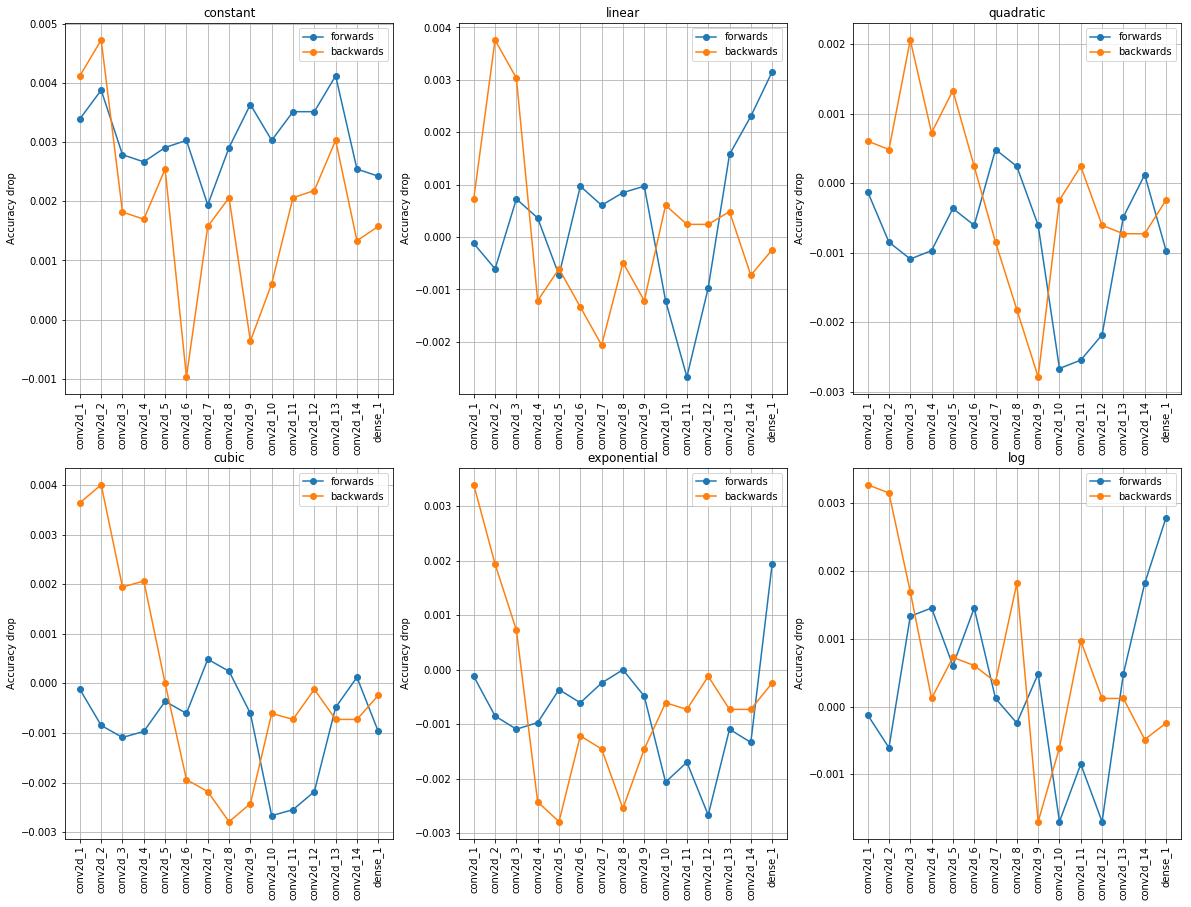

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
ax = axes.flat
x = np.arange(1, len(layer_names) + 1, 1)

for i, k in enumerate(f_acc_drop_w.keys()):
    forwards = [f_acc_drop_w[k][i] for i in f_acc_drop_w[k]]
    backwards = [r_acc_drop_w[k][i] for i in r_acc_drop_w[k]]
    # values are stored in reverse in the dictionary, 
    #hence need to be aligned with the forwards case
    backwards.reverse()
    
    ax[i].plot(x, forwards, 'o-', label='forwards')
    ax[i].plot(x, backwards, 'o-', label='backwards')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    ax[i].set_title(k)
    ax[i].set_ylabel('Accuracy drop')
    ax[i].grid()
    ax[i].legend()

#### Activations

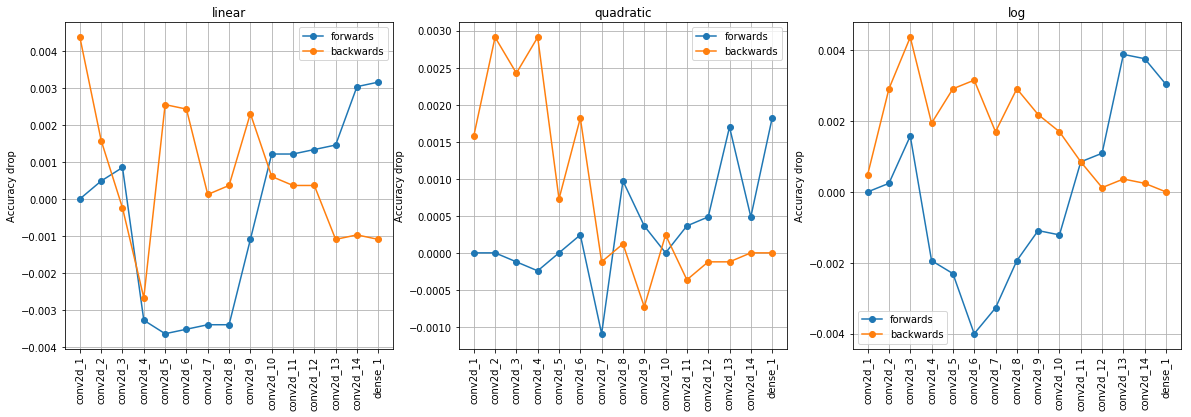

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ax = axes.flat
x = np.arange(1, len(layer_names) + 1, 1)

for i, k in enumerate(r_acc_drop_a.keys()):
    forwards = [f_acc_drop_a[k][i] for i in f_acc_drop_a[k]]
    backwards = [r_acc_drop_a[k][i] for i in r_acc_drop_a[k]]
    backwards.reverse()
    ax[i].plot(x, forwards, 'o-', label='forwards')
    ax[i].plot(x, backwards, 'o-', label='backwards')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    ax[i].set_title(k)
    ax[i].set_ylabel('Accuracy drop')
    ax[i].grid()
    ax[i].legend()

#### Memory consumption

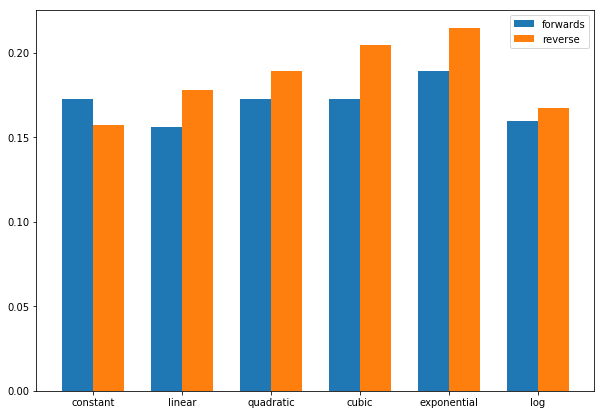

In [20]:
f_memory_MB = get_weights_memory_per_alloc_type(f_opt_params_w, num_params, 'forwards')
r_memory_MB = get_weights_memory_per_alloc_type(r_opt_params_w, num_params, 'reverse')

alloc_types = ['constant', 'linear', 'quadratic', 'cubic', 'exponential', 'log']
plt.figure(figsize=(10, 7))
width = 0.35
x = np.arange(len(f_memory_MB))
plt.bar(x, f_memory_MB, width, label='forwards');
plt.bar(x + width, r_memory_MB, width, label='reverse');
plt.xticks(x + width/2, alloc_types, rotation='horizontal');
plt.legend();

# SVHN 2

In [26]:
num_params = [864, 9216, 9216, 9216, 9216, 9216, 18432, 36864, 36864, 36864, 36864, 36864, 36864, 36864, 640]

In [31]:
f_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L SVHN 2/'
f_acc_drop_w, f_acc_drop_a, f_opt_params_w, f_opt_params_a = get_data(f_path)

r_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/R Sequential L SVHN 2/'
r_acc_drop_w, r_acc_drop_a, r_opt_params_w, f_opt_params_a = get_data(r_path)

In [32]:
layer_names = f_acc_drop_w['constant'].keys()

#### Weights

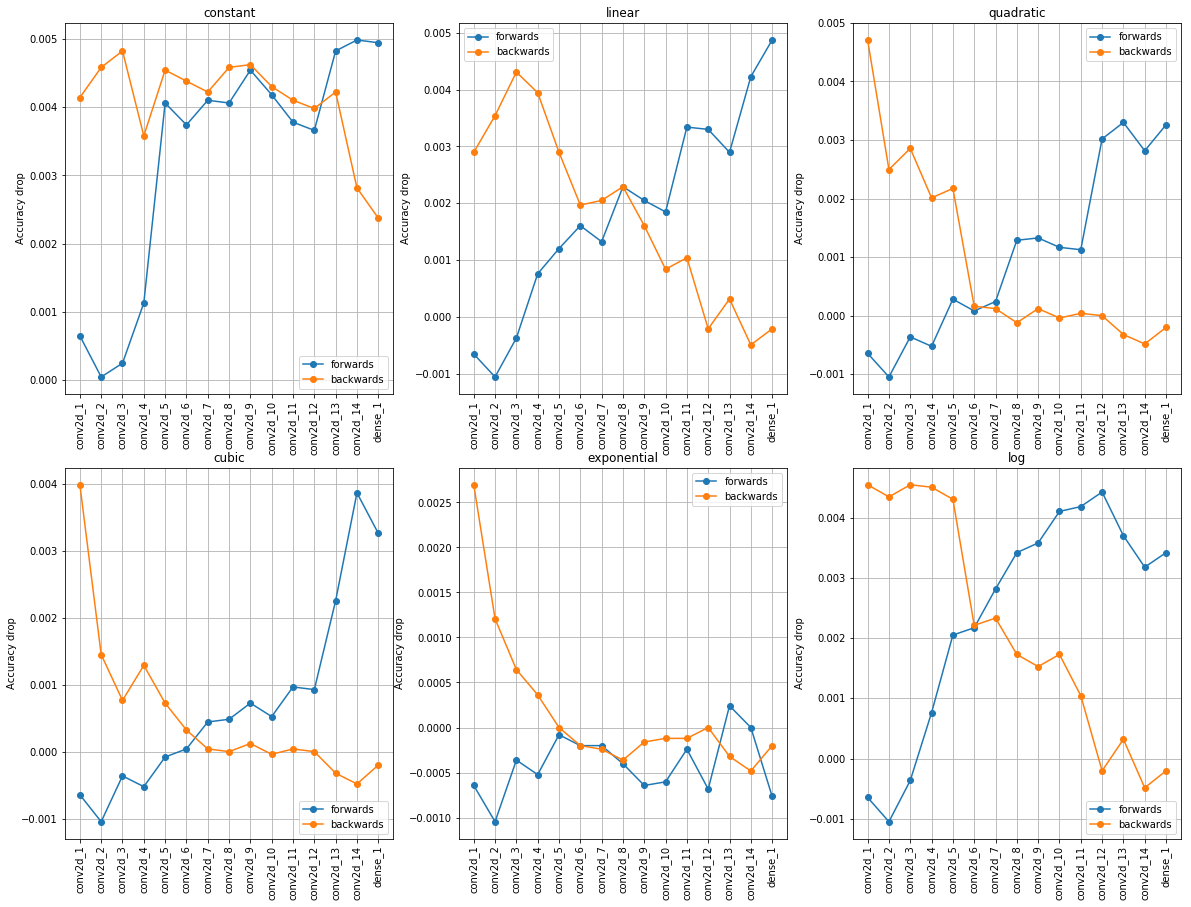

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
ax = axes.flat
x = np.arange(1, len(layer_names) + 1, 1)

for i, k in enumerate(f_acc_drop_w.keys()):
    forwards = [f_acc_drop_w[k][i] for i in f_acc_drop_w[k]]
    backwards = [r_acc_drop_w[k][i] for i in r_acc_drop_w[k]]
    # values are stored in reverse in the dictionary, 
    #hence need to be aligned with the forwards case
    backwards.reverse()
    
    ax[i].plot(x, forwards, 'o-', label='forwards')
    ax[i].plot(x, backwards, 'o-', label='backwards')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    ax[i].set_title(k)
    ax[i].set_ylabel('Accuracy drop')
    ax[i].grid()
    ax[i].legend()

#### Activations

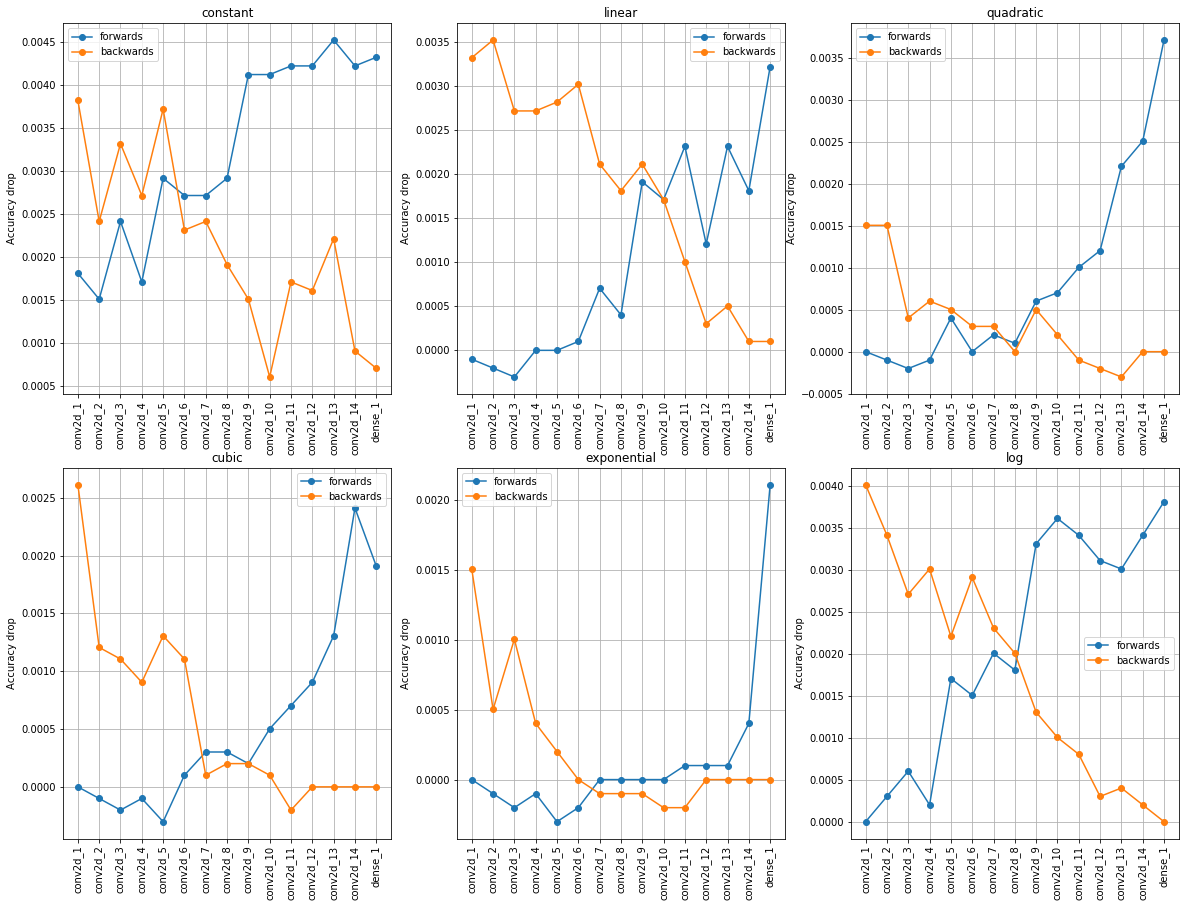

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
ax = axes.flat
x = np.arange(1, len(layer_names) + 1, 1)

for i, k in enumerate(f_acc_drop_a.keys()):
    forwards = [f_acc_drop_a[k][i] for i in f_acc_drop_a[k]]
    backwards = [r_acc_drop_a[k][i] for i in r_acc_drop_a[k]]
    backwards.reverse()
    ax[i].plot(x, forwards, 'o-', label='forwards')
    ax[i].plot(x, backwards, 'o-', label='backwards')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    ax[i].set_title(k)
    ax[i].set_ylabel('Accuracy drop')
    ax[i].grid()
    ax[i].legend()

#### Memory consumption

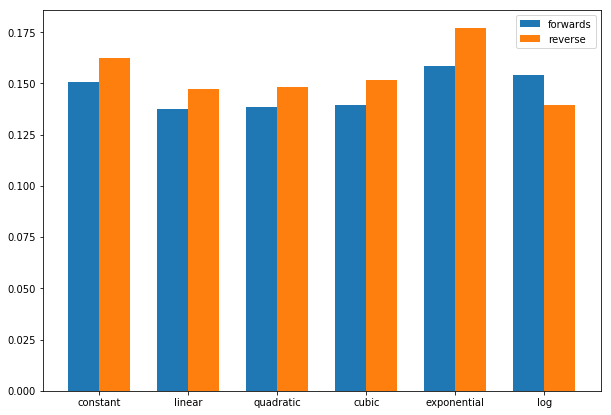

In [35]:
f_memory_MB = get_weights_memory_per_alloc_type(f_opt_params_w, num_params, 'forwards')
r_memory_MB = get_weights_memory_per_alloc_type(r_opt_params_w, num_params, 'reverse')

alloc_types = ['constant', 'linear', 'quadratic', 'cubic', 'exponential', 'log']
plt.figure(figsize=(10, 7))
width = 0.35
x = np.arange(len(f_memory_MB))
plt.bar(x, f_memory_MB, width, label='forwards');
plt.bar(x + width, r_memory_MB, width, label='reverse');
plt.xticks(x + width/2, alloc_types, rotation='horizontal');
plt.legend();